<a href="https://colab.research.google.com/github/mahdiSheykhiGithub/B-W-to-Color-U-Net-Powered-Image-Colorization/blob/main/U_Net_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Imports

In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 52.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Input, concatenate
from keras_cv.layers import Grayscale
from keras.utils import plot_model

Using TensorFlow backend


# Load images

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/faces/dataset/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/faces/dataset/val'

In [ ]:
datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_datagen = datagen.flow_from_directory(train_path, target_size=(256,256), batch_size=25, class_mode='input')
val_datagen = datagen.flow_from_directory(val_path, target_size=(256,256), batch_size=25, class_mode='input')

Found 3000 images belonging to 1 classes.
Found 143 images belonging to 1 classes.


In [ ]:
batch1 = next(train_datagen)

In [ ]:
batch1[0][0].shape

(256, 256, 3)

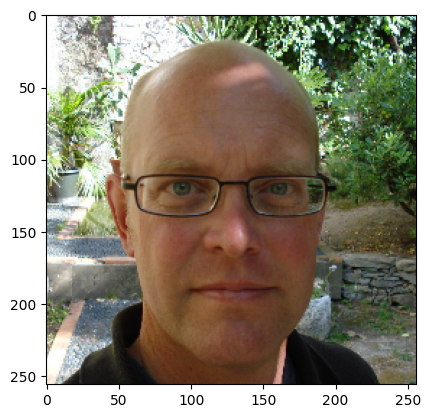

In [ ]:
plt.imshow(batch1[1][8])

# Modeling


In [ ]:
input = Input(shape=(256, 256, 3))
gray_scale = tf.image.rgb_to_grayscale(input)

conv1_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(gray_scale)
conv1_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_encoder)
pool1_encoder = MaxPool2D(pool_size=(2, 2))(conv1_encoder)

conv2_encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1_encoder)
conv2_encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_encoder)
pool2_encoder = MaxPool2D(pool_size=(2, 2))(conv2_encoder)

conv3_encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2_encoder)
conv3_encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_encoder)
pool3_encoder = MaxPool2D(pool_size=(2, 2))(conv3_encoder)

conv4_encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3_encoder)
conv4_encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_encoder)
pool4_encoder = MaxPool2D(pool_size=(2, 2))(conv4_encoder)

conv5_encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4_encoder)
conv5_encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5_encoder)

upconv1_decoder = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5_encoder)
concat1 = concatenate([conv4_encoder, upconv1_decoder])
conv1_decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
conv1_decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(conv1_decoder)

upconv2_decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv1_decoder)
concat2 = concatenate([conv3_encoder, upconv2_decoder])
conv2_decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
conv2_decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2_decoder)

upconv3_decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_decoder)
concat3 = concatenate([conv2_encoder, upconv3_decoder])
conv3_decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
conv3_decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_decoder)

upconv4_decoder = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3_decoder)
concat4 = concatenate([conv1_encoder, upconv4_decoder])
conv4_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(concat4)
conv4_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4_decoder)

output = Conv2D(3, (1, 1), activation='sigmoid', name='output_color')(conv4_decoder)

model = Model(inputs=[input], outputs=[output])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.image.rgb_to_grayscale   (None, 256, 256, 1)          0         ['input_1[0][0]']             
 (TFOpLambda)                                                                                     
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['tf.image.rgb_to_grayscale[0]
                                                                    [0]']                         
                                                                                              

In [ ]:
steps_per_epoch = len(train_datagen)
validation_steps = len(val_datagen)

In [ ]:
opt = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer=opt, loss=loss)

In [ ]:
history = model.fit(
    train_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=val_datagen,
    validation_steps=validation_steps,
    verbose=2
)

120/120 - 164s - loss: 0.0442 - val_loss: 0.0462 - 164s/epoch - 1s/step


# Evaluating

In [ ]:
gray_input = model.get_layer('tf.image.rgb_to_grayscale').output
color_output = model.get_layer('output_color').output
pred_model = Model(inputs=gray_input, outputs=color_output)

In [ ]:
pred_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[1][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[1][0]']            
 D)                                                                                         

In [ ]:
from glob import glob
import cv2

In [ ]:
img_path = glob('/content/drive/MyDrive/Colab Notebooks/faces/dataset/val/faces/*.png')
img_path = img_path[:200]

color_img = []
gray_img = []

for path in img_path:
  img_bgr = cv2.resize(cv2.imread(path), (256,256))
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  color_img.append(img)
  img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
  gray_img.append(img)

color_img = np.array(color_img) / 255.0
gray_img = np.array(gray_img) / 255.0

In [ ]:
gray_img.shape

(143, 256, 256)

In [ ]:
pred_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 input_gray (Conv2D)         (None, 256, 256, 32)         320       ['input_3[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         9248      ['input_gray[1][0]']          
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[2][0]']              
 D)                                                                                         

In [ ]:
pred_img = pred_model.predict(gray_img)

5/5 [==============================] - 15s 1s/step


In [ ]:
len(pred_img)

143

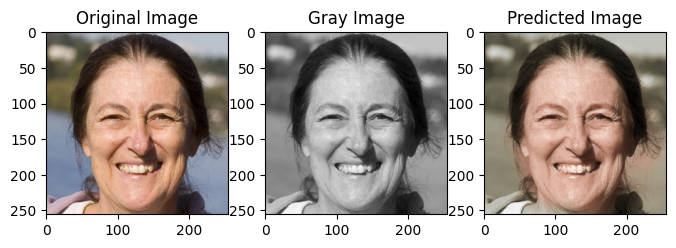

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.imshow(color_img[4])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(gray_img[4], cmap='gray')
plt.title('Gray Image')

plt.subplot(1,3,3)
plt.imshow(pred_img[4])
plt.title('Predicted Image')

plt.show()

In [ ]:
pred_model.save('/content/drive/MyDrive/Colab Notebooks/faces/pred_model2.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/faces/model_weights.h5')